# Manifold Intersections

Eigen-spectrum perturbations off of periodic orbits in the circular restricted 
three-body problem produce tubes of trajectories --- manifolds --- which are 
_invariant_: once a spacecraft enters these manifolds, the model equations
state that the spacecraft stays in the state space defined by the manifold's 
surface for all time. 

## Dependency Management

The following dependencies are used in this notebook.


In [1]:
import Pkg
Pkg.activate(joinpath(@__DIR__, ".."))
Pkg.develop(; url=joinpath(@__DIR__, "..", ".."))
Pkg.instantiate()

using SPICE, SPICEKernels
using GeneralAstrodynamics, Plots
using OrdinaryDiffEq, StaticArrays

furnsh(
    de432s(),                 # position and velocity data for nearby planets
    latest_leapseconds_lsk(), # timekeeping, parsing epochs
    gm_de440(),               # mass parameters for major solar system bodies
    pck00011(),               # physical properties of major solar system bodies
)

  Activating project at `~/Projects/Astrodynamics/GeneralAstrodynamics.jl/paper`
   Resolving package versions...
    Updating `~/Projects/Astrodynamics/GeneralAstrodynamics.jl/paper/Project.toml`
  [8068df5b] ~ GeneralAstrodynamics v1.0.0 `..` ⇒ v1.0.0 `~/Projects/Astrodynamics/GeneralAstrodynamics.jl`
    Updating `~/Projects/Astrodynamics/GeneralAstrodynamics.jl/paper/Manifest.toml`
  [8068df5b] ~ GeneralAstrodynamics v1.0.0 `..` ⇒ v1.0.0 `~/Projects/Astrodynamics/GeneralAstrodynamics.jl`


## Periodic Orbits

First, let's compute a periodic orbit about Sun-Earth L2 (lagrange point \#2).

In [2]:
orbit, period = let system = CR3BParameters("sun", "earth")
    u, T = halo(system.μ, 2; amplitude=1e-4)
    Orbit(CartesianState(u), system), T
end

orbit

Orbit in Circular Restricted Three Body Dynamics

  CartesianState with eltype Float64
  
    x: 1.0083813698126463
    y: 0.0
    z: 9.331179561949786e-5
    ẋ: 0.0
    ẏ: 0.009754824993718688
    ż: 0.0

  CR3BParameters with eltype Float64
  
    μ: 3.0034805945423635e-6


We can plot the orbit using built-in plotting recipes. Let's keep this figure
handle as a variable too, so we can add on perturbed trajectories later.

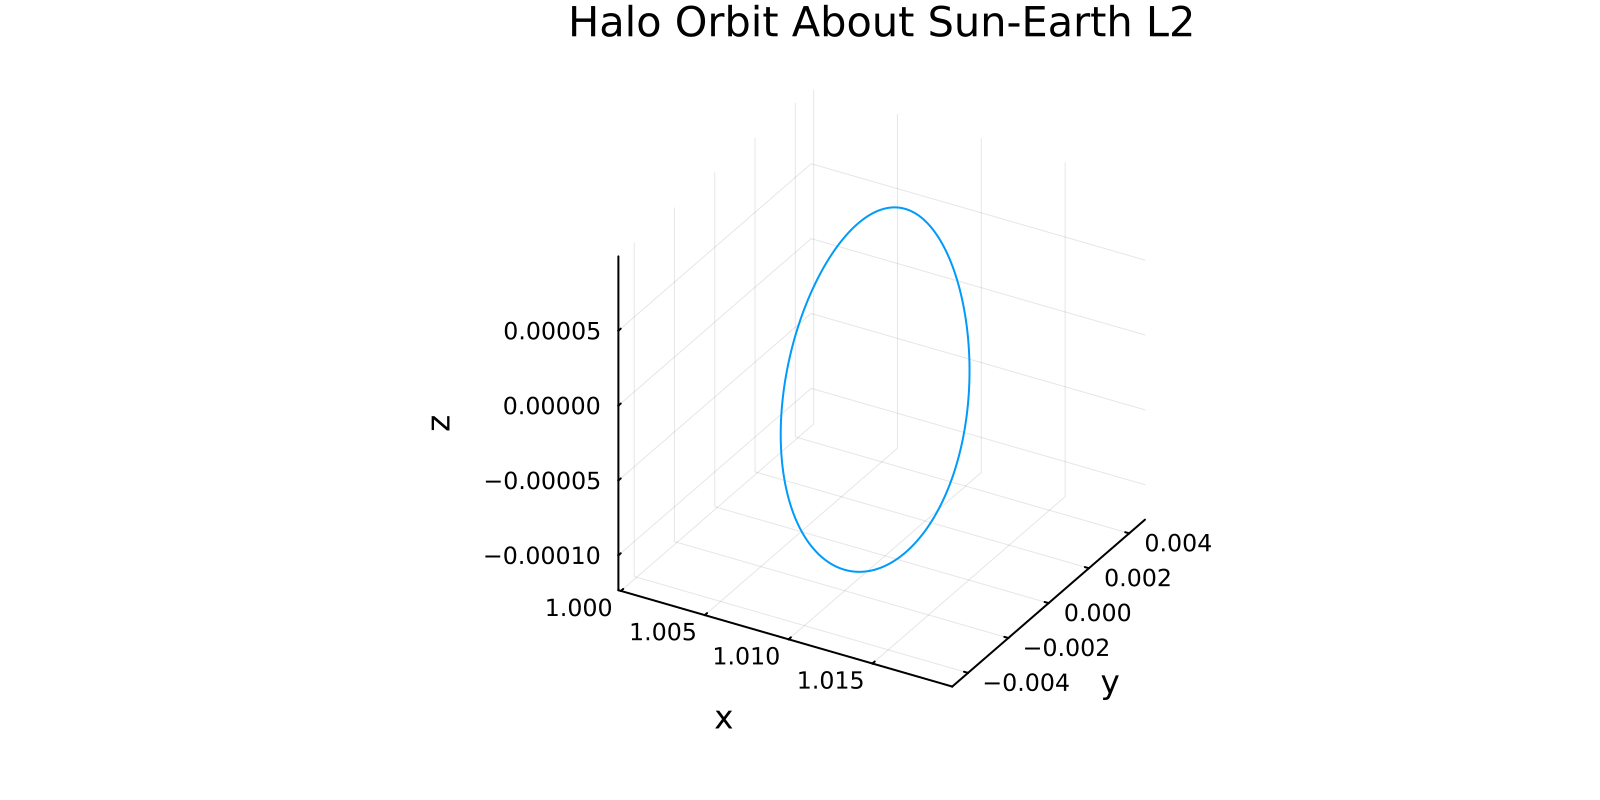

In [3]:
trajectory = propagate(orbit, period, stm = true)

figure = plot(
    trajectory; 
    idxs=(:x, :y, :z), title = "Halo Orbit About Sun-Earth L2",
    aspect_ratio = :equal, label = :none, background = :transparent,
    dpi = 200, size = (800, 400)
)

## Manifold Solvers

The `AstrodynamicalSolvers` and `AstrodynamicalCalculations` packages, which are
both included in `GeneralAstrodynamics`, provide functions which perturb a 
Cartesian state in the appropriate direction
to produce _stable_ and _unstable_  (or _convergent_ and _divergent_) manifolds
about periodic orbits in the circular restricted three-body problem. You can 
compute these perturbations yourself by using the `perturb` and `perturb!` 
methods, and you can compute convergent manifolds and divergent manifolds 
with `converge`, `diverge`, `converge!`, and `diverge!`. 

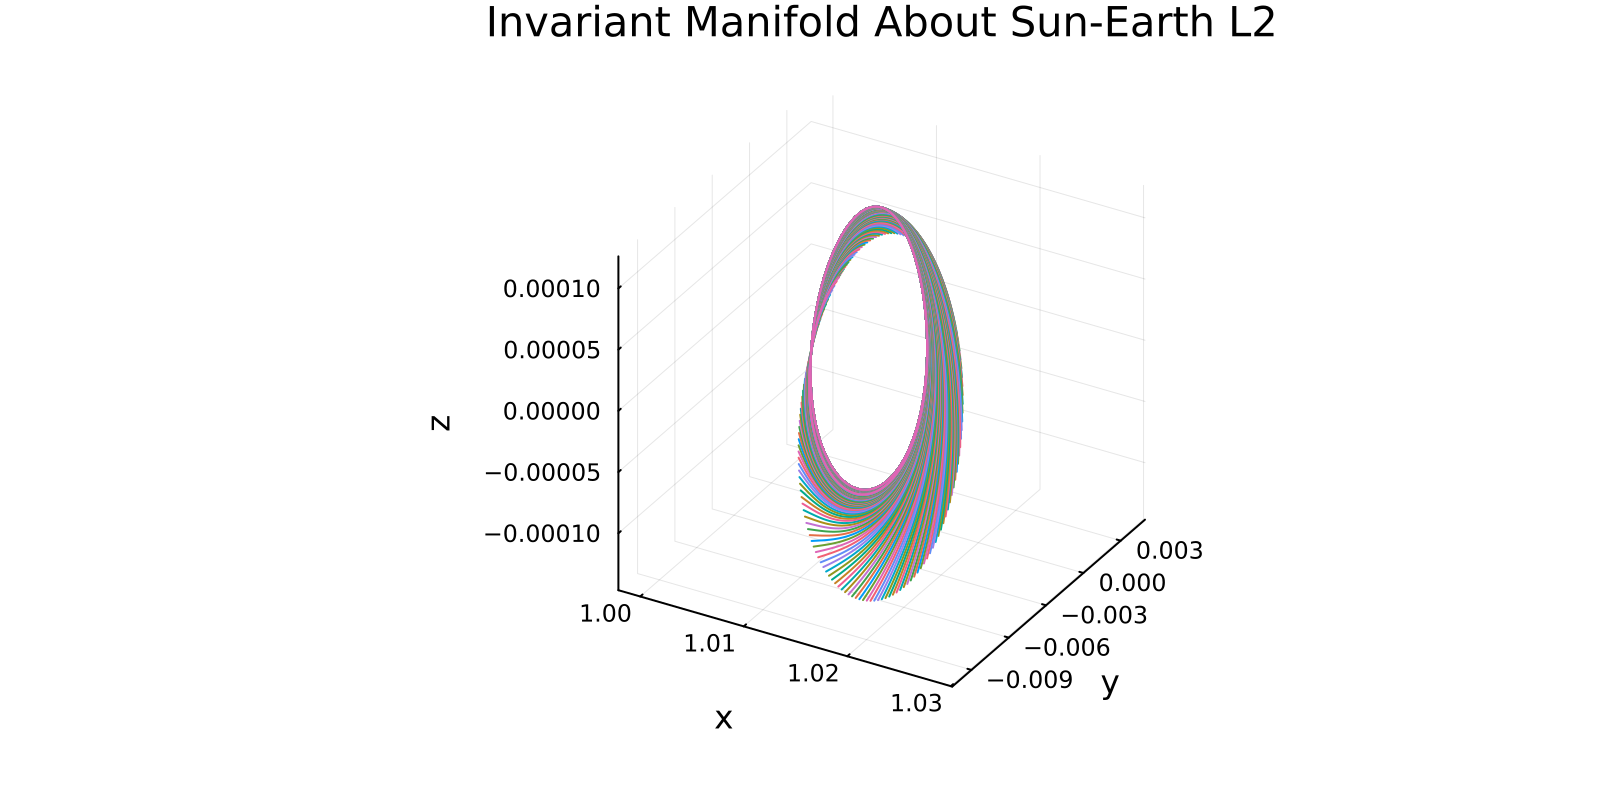

In [4]:
states = [CartesianState(u[begin:begin+5]) for u in trajectory.u]
stms = [CartesianSTM(u[begin+6:end]) for u in trajectory.u]

Φ = last(stms)

for (u, ϕ) in zip(states, stms)
    _orbit = Orbit(diverge(u, ϕ, Φ), AstrodynamicalModels.parameters(orbit))
    _trajectory = propagate(_orbit, 2 * period)
    
    plot!(figure, _trajectory; idxs = (:x, :y, :z), label = :none)
end

plot!(figure; title = "Invariant Manifold About Sun-Earth L2")

figure